# Poor Confidence Analysis
This analysis aims to improve the NER model by studying the predictions done by the model. This is done firstly by identifying the weakness or limitations discovered from the prediction results. So, by looking at the outputs, the confidence score can be the area of focus for this analysis.

The idea of this analysis is to find out if the low confidence scores are justifiable. For example, is the confidence score related to the volume of the dataset, frequency of the labels, or word rarity?

This can be determined by answering these questions:
1. Is there a correlation between label frequency and confidence scores?    (`label`)
2. Are low-confidence predictions associated with text frequency/rarity?    (`text`)
3. Do certain entity types show systematic confidence patterns?             (`label`)
4. Is confidence score correlated with word length or complexity?           (`text`)
5. Does context window size affect confidence?

Based on these questions, 

* If low scores correlate with rare labels: Augment training data for underrepresented classes.
* If low scores correlate with rare words: Add domain-specific vocabulary for training.
* If low scores are consistent with certain label group: Focused annotation to cator specific labelings.
* If low scores are consistent with longer words/phrase: Review span detection. (KIV)
* If low scores cluster in specific positions: Review context window. (KIV)

If all are unclear: Review model architecture or hyperparameter tuning

-------------
------
## Data Pre-processing

#### Import Libraries

In [496]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats             # correlation

#### Load Dataset

In [497]:
# load csv
df = pd.read_csv('results_main.csv')
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [498]:
df.info

<bound method DataFrame.info of         start     end                 text    label     score
0           0      13        operasi kesan    EVENT  0.630561
1          36      42               ec120b  PRODUCT  0.817231
2          62      67                ipcmc      ORG  0.962938
3         110     125      utusan malaysia      ORG  0.784653
4         170     180           ezad lazim   PERSON  0.918969
...       ...     ...                  ...      ...       ...
15921  963869  963875               negara      LOC  0.810654
15922  963877  963888          johor bahru      LOC  0.759652
15923  963975  963984            singapura      LOC  0.734750
15924  964020  964039  minyak petrol ron95  PRODUCT  0.777760
15925  964077  964082                johor      LOC  0.838383

[15926 rows x 5 columns]>

In [499]:
# normalize text
df['text'] = df['text'].str.lower()
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [500]:
# duplicates
df.drop_duplicates().head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


-------------
--------
## Exploratory Data Analysis
This part aims to explore the dataset in hopes to uncover hidden perspectives.

#### Label Distribution

In [501]:
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [502]:
# label distribution
df['label'].value_counts()

label
ORG            3933
PERSON         3603
LOC            3424
EVENT          1022
GPE             820
PRODUCT         779
TIME            713
MONEY           498
QUANTITY        346
LAW             318
WORK_OF_ART     165
PERCENT         147
CARDINAL         78
NORP             53
FAC              25
ORDINAL           2
Name: count, dtype: int64

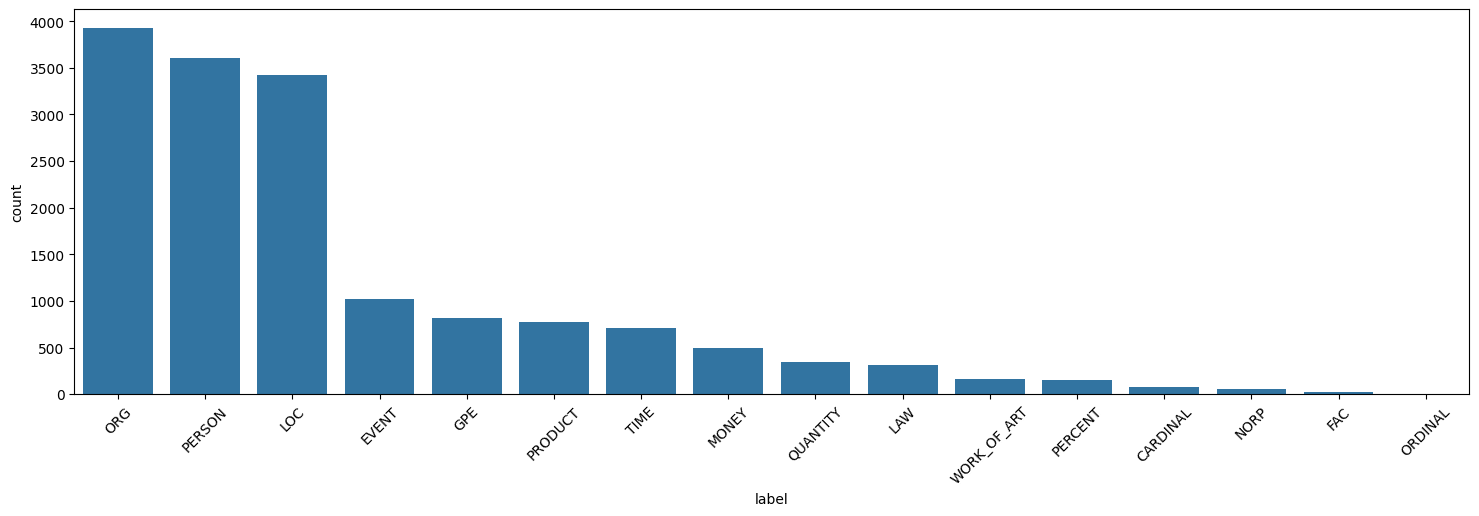

In [503]:
# visualize
label_freq = df['label'].value_counts().index

plt.figure(figsize=(18,5))
sns.countplot(x=df['label'],data=df, order=label_freq)
plt.xticks(rotation=45)
plt.show()

From this graph, it is safe to assume that the high-frequency labels are the 3 highest, while the others are teh low-frequency labels. This is because the gap between the third and the fourth highest is relatively big (1500 vs 500), when compared to other inter-label gaps.

#### High and Low Frequency Labels

In [504]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [505]:
# drop columns
freq = df.drop(['start','end','text'], axis=1)
freq.head()

,label,score
0,EVENT,0.630561
1,PRODUCT,0.817231
2,ORG,0.962938
3,ORG,0.784653
4,PERSON,0.918969


In [506]:
# list labels
freq['label'].unique()

array(['EVENT', 'PRODUCT', 'ORG', 'PERSON', 'QUANTITY', 'GPE', 'LOC',
       'TIME', 'MONEY', 'LAW', 'CARDINAL', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL'], dtype=object)

In [507]:
# split into higher and lower frequency groups
high_label = ['PERSON','ORG','LOC']
low_label = ['PRODUCT', 'QUANTITY', 'EVENT', 'GPE',
       'CARDINAL', 'TIME', 'LAW', 'MONEY', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL']

freq_high = freq[freq['label'].isin(high_label)]
freq_low = freq[freq['label'].isin(low_label)]

#### Confidence Score Disctribution

In [508]:
# get mean confidence score
conf = df.groupby('label')['score'].mean().reset_index()
conf = conf.sort_values('score', ascending=False)

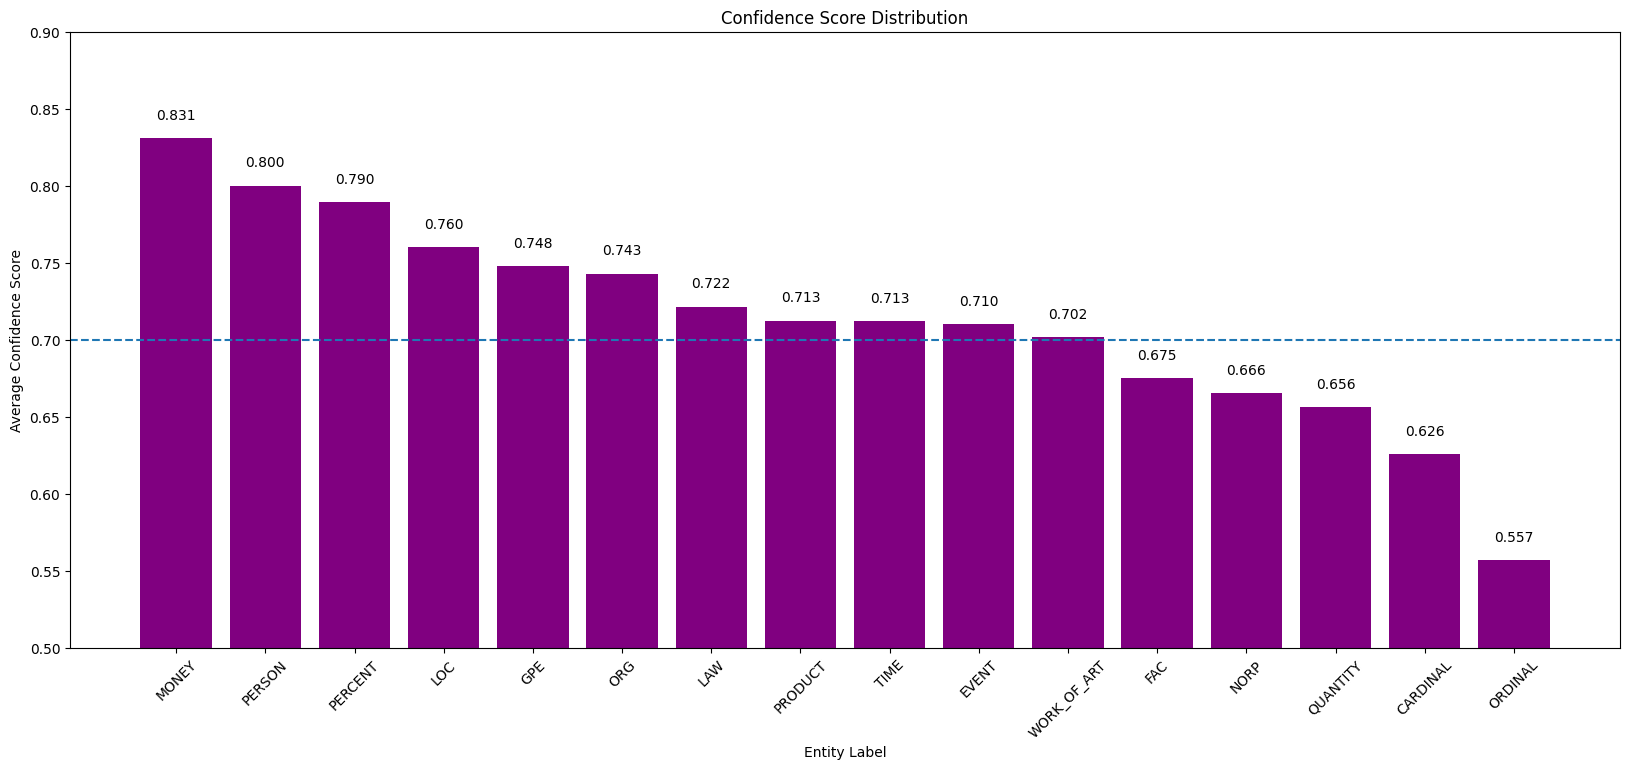

In [536]:
# visualize
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 1, 1) 
bars = ax.bar(conf['label'], conf['score'], color='purple')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height + 0.01, f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

ax.set_title('Confidence Score Distribution')
ax.set_xlabel('Entity Label')
ax.set_ylabel('Average Confidence Score')
ax.set_ylim(0.5, 0.9)
ax.axhline(y=0.7,linestyle='--')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()


Based on this distribution, there are 5 labels that are considered to be low-confidence.

#### Confidence Scores in High and Low Frequency Labels

In [510]:
# get mean score
label_score_mean_high = freq_high.groupby('label')['score'].mean().reset_index()
label_score_mean_low = freq_low.groupby('label')['score'].mean().reset_index()

In [511]:
# sort mean score
label_score_mean_high = label_score_mean_high.sort_values('score', ascending=False)
label_score_mean_low = label_score_mean_low.sort_values('score', ascending=False)

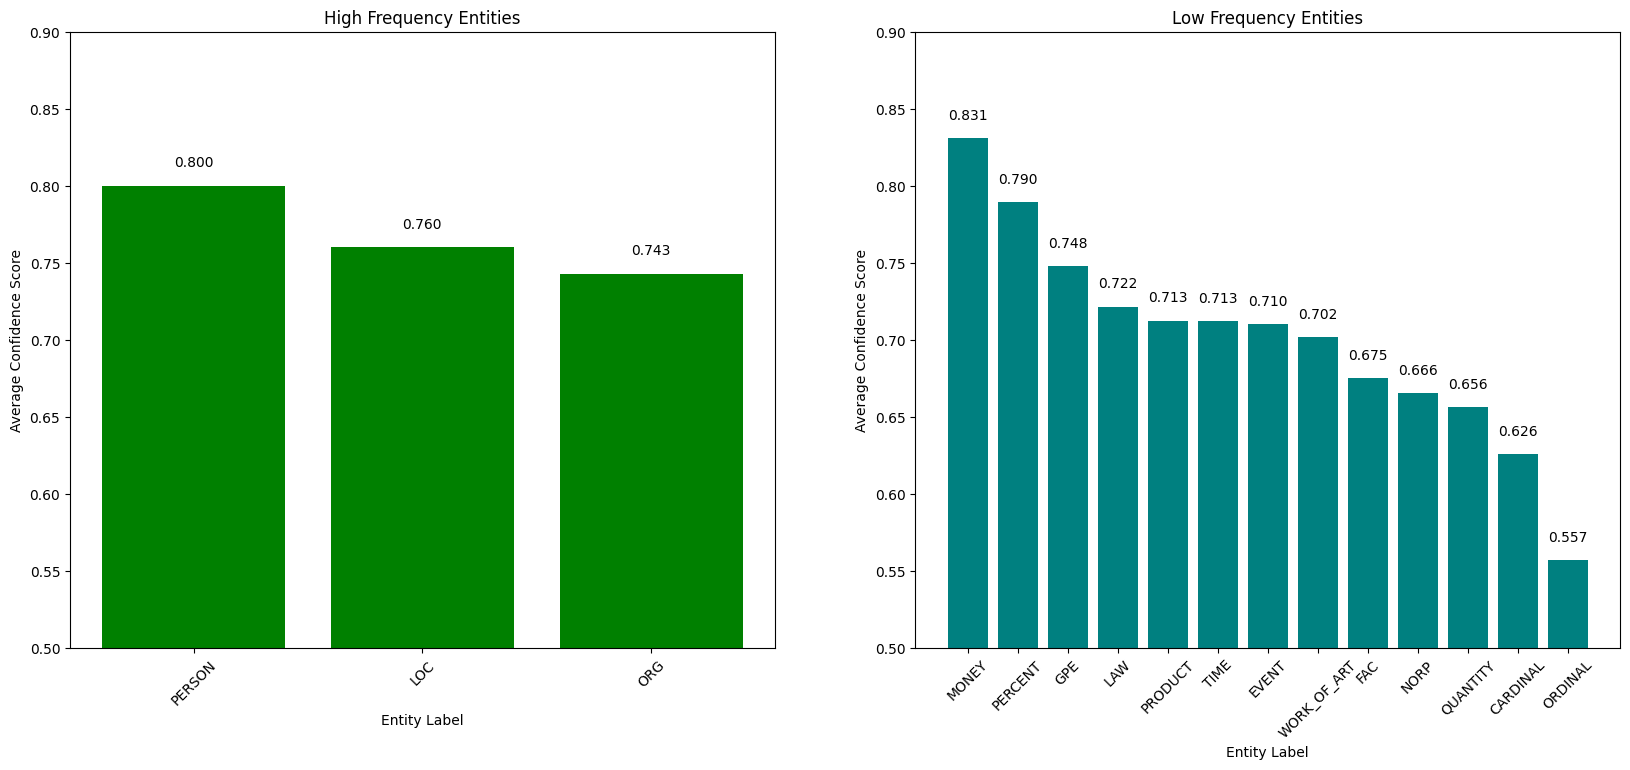

In [512]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# high frequency labels
bars1 = ax1.bar(label_score_mean_high['label'], 
               label_score_mean_high['score'],
               color='green')

# labeling
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax1.set_title('High Frequency Entities')
ax1.set_xlabel('Entity Label')
ax1.set_ylabel('Average Confidence Score')
ax1.set_ylim(0.5, 0.9)
ax1.tick_params(axis='x', rotation=45)

# low frequency labels
bars2 = ax2.bar(label_score_mean_low['label'], 
               label_score_mean_low['score'],
               color='teal')

# labeling
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax2.set_title('Low Frequency Entities')
ax2.set_xlabel('Entity Label')
ax2.set_ylabel('Average Confidence Score')
ax2.set_ylim(0.5, 0.9)
ax2.tick_params(axis='x', rotation=45)

# display
plt.tight_layout
plt.show()

Based on these graphs, the lowest confidence score for the high-frequency labels is around 76%, while the highest confidence score for the low-frequency labels is around 82%. This means that even if the label is relatively rare, the confidence score can still be high. Even so, it cannot be a certain that there is no correlation between the label rarity and the confidence score. Therefore, a correlation analysis can be done to further confirm this.

#### Low Rarity Texts

In [513]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [514]:
# text frequency
text_freq = df['text'].value_counts().reset_index() 
text_freq

,text,count
0,utusan malaysia,416
1,kuala lumpur,258
2,malaysia,240
3,polis,131
4,petaling jaya,100
...,...,...
6948,pukul 9 pagi,1
6949,dua dekad lalu,1
6950,muflis,1
6951,pulau tropika,1


In [515]:
# texts that appeared only once
text_low = text_freq[text_freq['count'] == 1]
text_low

,text,count
2242,"rm20,000",1
2243,$3 juta,1
2244,rizal ali,1
2245,seksyen 14(d) akta kesalahan-kesalahan seksual...,1
2246,vladimir putih,1
...,...,...
6948,pukul 9 pagi,1
6949,dua dekad lalu,1
6950,muflis,1
6951,pulau tropika,1


From this, there are about 4000 texts that appeared only once. That's more than half of the whole dataset (6000 texts)! This is also while excluding the texts that appeared only twice or thrice.

However, this is to be expected since texts with unique nomenclature or numbers might be a factor to this phenomenon. 

#### Distribution of Confidence Score in Low Rarity Texts

In [516]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [517]:
# get score for low rarity texts
text_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

text_low_conf = pd.merge(text_freq, text_conf, on='text')
text_low_conf = text_low_conf[text_low_conf['count'] == 1]
text_low_conf.sort_values('score',ascending=False)

,text,count,score
3411,harvey elliott,1,0.995564
3535,novak djokovic,1,0.995105
3366,harry maguire,1,0.994720
3667,mimi fly,1,0.994010
3370,muhammad yunus,1,0.993510
...,...,...,...
2387,kejohanan sukan sea,1,0.500327
5994,calon mentua,1,0.500295
2416,kampung glam,1,0.500206
5103,bekalan makanan,1,0.500189


Here, we can see that the rare texts has the confidence score at both high and low ends.

In [518]:
score_low = df[df['score'] < 0.7]
score_low.sort_values('score',ascending=False)

,start,end,text,label,score
5734,255241,255253,pelitup muka,PRODUCT,0.699989
2462,47867,47870,ceo,PERSON,0.699948
4201,130639,130648,pertemuan,EVENT,0.699943
961,19228,19243,utusan malaysia,ORG,0.699939
9514,577970,577993,hospital tuanku fauziah,ORG,0.699884
...,...,...,...,...,...
876,17470,17485,bekalan makanan,PRODUCT,0.500189
12794,851879,851885,gambar,WORK_OF_ART,0.500136
1788,35089,35094,kubur,ORG,0.500109
12213,805379,805386,majikan,ORG,0.500095


There are about 5000 texts that has low confidence scores.

--------------
--------------
## Data Analysis

-------------
### Q1: Is there a correlation between label frequency and confidence scores?
Study on the mean confidence scores and label frequency correlation. This is to see if high frequency means high confidence score, or vice versa.

#### Data Preparation

In [519]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [520]:
# create new dataset
q1_label = df['label'].value_counts().reset_index()         # get label frequency
q1_conf = df.groupby('label')['score'].mean().reset_index() # get mean confidence score

label_analysis = pd.merge(q1_label, q1_conf, on='label')
label_analysis.sort_values('score',ascending=False)

,label,count,score
7,MONEY,498,0.831429
1,PERSON,3603,0.800305
11,PERCENT,147,0.789823
2,LOC,3424,0.760253
4,GPE,820,0.747949
0,ORG,3933,0.743217
9,LAW,318,0.721854
5,PRODUCT,779,0.712661
6,TIME,713,0.712611
3,EVENT,1022,0.710239


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship
3. Shapiro-Wilk test - to determine if its normally distributed

**Null hypothesis:**\
There is no correlation between label frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between label frequency and confidence scores.

In [521]:
# pearson
pearson_corr, p_value = stats.pearsonr(
    label_analysis['count'],
    label_analysis['score']
)

# spearman
spearman_rho, p_spearman = stats.spearmanr(
    label_analysis['count'],
    label_analysis['score']
)

# normality test
shapiro_test = stats.shapiro(label_analysis['score'])

In [522]:
print(f"Spearman rho: {spearman_rho:.3f}")
print(f"Spearman p: {p_spearman:.4f}\n")
print(f"Pearson r: {pearson_corr:.3f}")
print(f"Pearson p: {p_value:.4f}\n")
print(f"Shapiro-Wilk W:{shapiro_test[0]:.3f}")
print(f"Shapiro-Wilk p: {shapiro_test[1]:.4f}\n")

Spearman rho: 0.635
Spearman p: 0.0082

Pearson r: 0.469
Pearson p: 0.0668

Shapiro-Wilk W:0.979
Shapiro-Wilk p: 0.9558



Based on these results:
* There is a significant (p < 0.05) strong positive monotonic relationship (rho > 0.6). This means that as label frequency increases, confidence scores consistently increase, but not necessarily in a straight-line pattern - Spearman correlation test
* There is a significant (p < 0.05) moderate positive linear relationship (r > 0.4, r < 0.6). This means that higher frequency moderately predicts higher confidence in a linear pattern. - Pearson correlation test
* Since the rho > r, the monotonic relationship is stronger than the linear relationship. This means that even though higher frequency boosts the confidence score, the boost will decrease with higher frequency.
* Since both of these tests are significant, the results are not random.
* The data is normally distributed (p > 0.05). - Shapiro-Wilk test

Therefore, we reject the null hypothesis.

For fine-tuning, training data that focuses on the low-frequency labels can be used for augmentation.

In [523]:
# filter low-frequency labels in main dataset
q1_low_full = df[df['label'].isin(low_label)]
q1_low_full.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
12,338,340,31,QUANTITY,0.931890
13,377,385,malaysia,GPE,0.832705
16,425,434,kejuaraan,EVENT,0.646641


------------
### Q2: Are low-confidence predictions correlated with text frequency/rarity?
Study on the low confidence scores and text frequency. This is to see if lower rarity means lower confidence score, or vice versa.

#### Data Preparation

In [524]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [525]:
# create new dataset
q2_text = df['text'].value_counts().reset_index()           # get text frequency
q2_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

text_analysis = pd.merge(q2_text, q2_conf, on='text')
text_analysis

,text,count,score
0,utusan malaysia,416,0.715192
1,kuala lumpur,258,0.866004
2,malaysia,240,0.740992
3,polis,131,0.769234
4,petaling jaya,100,0.738126
...,...,...,...
6948,pukul 9 pagi,1,0.577997
6949,dua dekad lalu,1,0.774836
6950,muflis,1,0.570706
6951,pulau tropika,1,0.703507


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text frequency and confidence scores.

In [526]:
# pearson
pearson_corr, p_value = stats.pearsonr(
    text_analysis['count'],
    text_analysis['score']
)

# spearman
spearman_rho, p_spearman = stats.spearmanr(
    text_analysis['count'],
    text_analysis['score']
)

In [527]:
print(f"Spearman rho: {spearman_rho:.3f}")
print(f"Spearman p: {p_spearman:.4f}\n")
print(f"Pearson r: {pearson_corr:.3f}")
print(f"Pearson p: {p_value:.4f}\n")

Spearman rho: 0.026
Spearman p: 0.0295

Pearson r: 0.008
Pearson p: 0.4921



Based on these results:
* There is a significant (p < 0.05) but negligible monotonic relationship (rho < 0.1). This means that there is no meaningful relationship between text and confidence score. - Spearman correlation test
* There is no significant (p > 0.05) linear relationship (r < 0.1). This means that there is no evidence of linear relationship between text and confidence score. - Pearson correlation test

Therefore, we do not reject the null hypothesis.

The fine-tuning should be aimed at other factors instead.

This further justifies the EDA,  where the confidence scores are covered from both high and low ends from the texts, despite the rarity of the texts.

------------
### Q3: Do certain entity types show systematic confidence patterns?
Analyze low confidence score distributions per label type. This is to see whether certain labels are under-trained.

#### Data Preparation

In [528]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [529]:
# sort and filter score < 0.7
q3 = df.sort_values('score', ascending=False)
q3 = q3[q3['score'] < 0.7]
q3

,start,end,text,label,score
5734,255241,255253,pelitup muka,PRODUCT,0.699989
2462,47867,47870,ceo,PERSON,0.699948
4201,130639,130648,pertemuan,EVENT,0.699943
961,19228,19243,utusan malaysia,ORG,0.699939
9514,577970,577993,hospital tuanku fauziah,ORG,0.699884
...,...,...,...,...,...
876,17470,17485,bekalan makanan,PRODUCT,0.500189
12794,851879,851885,gambar,WORK_OF_ART,0.500136
1788,35089,35094,kubur,ORG,0.500109
12213,805379,805386,majikan,ORG,0.500095


In [530]:
# number of labels
print(f"number of labels with low-scores    : {len(q3['label'].unique())}")
print(f"number of labels on main            : {len(df['label'].unique())}")


number of labels with low-scores    : 16
number of labels on main            : 16


After comparing with the non-low confident scores, it can be inferred that the confidence scores are unrelated to the text label, but rather to the texts themselves. Therefore, we cannot do a label-focused annotations.

-----------
### Q4: Is confidence score correlated with word length or complexity?
Find the correlation between entity string length/number of texts and confidence scores.

In [531]:
# overview
df.head()

,start,end,text,label,score
0,0,13,operasi kesan,EVENT,0.630561
1,36,42,ec120b,PRODUCT,0.817231
2,62,67,ipcmc,ORG,0.962938
3,110,125,utusan malaysia,ORG,0.784653
4,170,180,ezad lazim,PERSON,0.918969


In [532]:
# get characters
q4 = df.copy()
q4['chara'] = df['text'].str.len()
q4.head()

,start,end,text,label,score,chara
0,0,13,operasi kesan,EVENT,0.630561,13
1,36,42,ec120b,PRODUCT,0.817231,6
2,62,67,ipcmc,ORG,0.962938,5
3,110,125,utusan malaysia,ORG,0.784653,15
4,170,180,ezad lazim,PERSON,0.918969,10


---------
### Q5: Does context window size affect confidence?
Examine scores relative to entity position in sentence (beginning, middle, end).